
# MLEM with projection data of an open PET geometry

This example demonstrates the use of the MLEM algorithm to minimize the negative Poisson log-likelihood function
using "sinogram" data from an open PET geometry.

\begin{align}f(x) = \sum_{i=1}^m \bar{y}_i (x) - y_i \log(\bar{y}_i (x))\end{align}

subject to

\begin{align}x \geq 0\end{align}

using the linear forward model

\begin{align}\bar{y}(x) = A x + s\end{align}

.. tip::
    parallelproj is python array API compatible meaning it supports different 
    array backends (e.g. numpy, cupy, torch, ...) and devices (CPU or GPU).
    Choose your preferred array API ``xp`` and device ``dev`` below.

<img src="https://mybinder.org/badge_logo.svg" target="https://mybinder.org/v2/gh/gschramm/parallelproj/master?labpath=examples">


In [1]:
from __future__ import annotations
from parallelproj import Array

import array_api_compat.numpy as xp

# import array_api_compat.cupy as xp
# import array_api_compat.torch as xp

import parallelproj
from array_api_compat import to_device
import array_api_compat.numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# choose a device (CPU or CUDA GPU)
if "numpy" in xp.__name__:
    # using numpy, device must be cpu
    dev = "cpu"
elif "cupy" in xp.__name__:
    # using cupy, only cuda devices are possible
    dev = xp.cuda.Device(0)
elif "torch" in xp.__name__:
    # using torch valid choices are 'cpu' or 'cuda'
    if parallelproj.cuda_present:
        dev = "cuda"
    else:
        dev = "cpu"


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: C:\Users\h\anaconda3\Library\bin\parallelproj_c.dll
        parallelproj CUDA lib         ..: C:\Users\h\anaconda3\Library\bin\parallelproj_cuda.dll
        parallelproj CUDA kernel file ..: C:\Users\h\anaconda3\Library\lib\projector_kernels.cu.1.10.1
        parallelproj CUDA present     ..: True
        parallelproj cupy enabled     ..: True
        


## Setup of the forward model $\bar{y}(x) = A x + s$

We setup a linear forward operator $A$ consisting of an
image-based resolution model, a non-TOF PET projector and an attenuation model

Here we create an open geometry with 6 sides and 5 rings corresponding to
a full geometry using 12 sides where 6 sides were removed.



In [2]:
num_rings = 1
scanner = parallelproj.RegularPolygonPETScannerGeometry(
    xp,
    dev,
    radius=65.0,
    num_sides=6,
    num_lor_endpoints_per_side=15,
    lor_spacing=2.3,
    ring_positions=xp.asarray([0.0], device=dev),
    symmetry_axis=2,
    phis=(2 * xp.pi / 12) * xp.asarray([-1, 0, 1, 5, 6, 7]),
)

setup the LOR descriptor that defines the sinogram



In [3]:
img_shape = (40, 40, 1)
voxel_size = (2.0, 2.0, 2.0)

lor_desc = parallelproj.RegularPolygonPETLORDescriptor(
    scanner,
    radial_trim=1,
    sinogram_order=parallelproj.SinogramSpatialAxisOrder.RVP,
)

proj = parallelproj.RegularPolygonPETProjector(
    lor_desc, img_shape=img_shape, voxel_size=voxel_size
)

# setup a simple test image containing a few "hot rods"
x_true = xp.ones(proj.in_shape, device=dev, dtype=xp.float32)
c0 = proj.in_shape[0] // 2
c1 = proj.in_shape[1] // 2

x_true[4, c1, :] = 5.0
x_true[8, c1, :] = 5.0
x_true[12, c1, :] = 5.0
x_true[16, c1, :] = 5.0

x_true[c0, 4, :] = 5.0
x_true[c0, 8, :] = 5.0
x_true[c0, 12, :] = 5.0
x_true[c0, 16, :] = 5.0

x_true[:2, :, :] = 0
x_true[-2:, :, :] = 0
x_true[:, :2, :] = 0
x_true[:, -2:, :] = 0

## Attenuation image and sinogram setup



In [4]:
# setup an attenuation image
x_att = 0.01 * xp.astype(x_true > 0, xp.float32)
# calculate the attenuation sinogram
att_sino = xp.exp(-proj(x_att))

## Complete PET forward model setup

We combine an image-based resolution model,
a non-TOF or TOF PET projector and an attenuation model
into a single linear operator.



In [5]:
## enable TOF - comment if you want to run non-TOF
# proj.tof_parameters = parallelproj.TOFParameters(
#    num_tofbins=13 * 5,
#    tofbin_width=12.0 / 5,
#    sigma_tof=12.0 / 5,
# )

# setup the attenuation multiplication operator which is different
# for TOF and non-TOF since the attenuation sinogram is always non-TOF
if proj.tof:
    att_op = parallelproj.TOFNonTOFElementwiseMultiplicationOperator(
        proj.out_shape, att_sino
    )
else:
    att_op = parallelproj.ElementwiseMultiplicationOperator(att_sino)

res_model = parallelproj.GaussianFilterOperator(
    proj.in_shape, sigma=4.5 / (2.35 * proj.voxel_size)
)

# compose all 3 operators into a single linear operator
pet_lin_op = parallelproj.CompositeLinearOperator((att_op, proj, res_model))

## Visualization of the geometry




C:\Users\h\AppData\Local\Temp\ipykernel_23200\4249726316.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


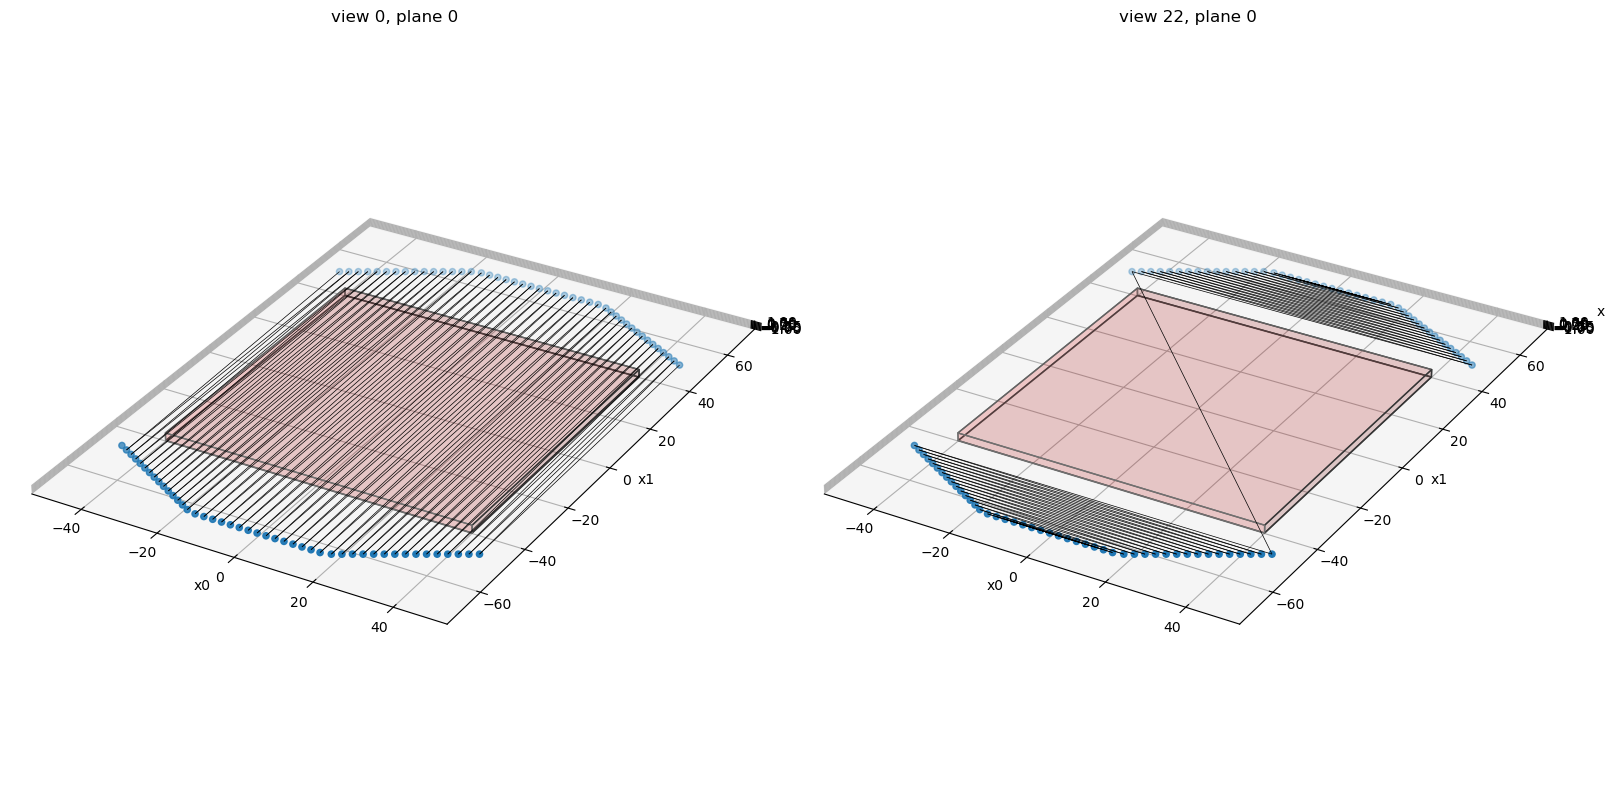

In [6]:
fig = plt.figure(figsize=(16, 8), tight_layout=True)
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
proj.show_geometry(ax1)
proj.show_geometry(ax2)
proj.lor_descriptor.show_views(
    ax1,
    views=xp.asarray([0], device=dev),
    planes=xp.asarray([num_rings // 2], device=dev),
    lw=0.5,
    color="k",
)
ax1.set_title(f"view 0, plane {num_rings // 2}")
proj.lor_descriptor.show_views(
    ax2,
    views=xp.asarray([proj.lor_descriptor.num_views // 2], device=dev),
    planes=xp.asarray([num_rings // 2], device=dev),
    lw=0.5,
    color="k",
)
ax2.set_title(f"view {proj.lor_descriptor.num_views // 2}, plane {num_rings // 2}")
fig.tight_layout()
fig.show()

## Simulation of projection data

We setup an arbitrary ground truth $x_{true}$ and simulate
noise-free and noisy data $y$ by adding Poisson noise.



In [7]:
# simulated noise-free data
noise_free_data = pet_lin_op(x_true)

# generate a contant contamination sinogram
contamination = xp.full(
    noise_free_data.shape,
    0.5 * float(xp.mean(noise_free_data)),
    device=dev,
    dtype=xp.float32,
)

noise_free_data += contamination

# add Poisson noise
# np.random.seed(1)
# y = xp.asarray(
#    np.random.poisson(parallelproj.to_numpy_array(noise_free_data)),
#    device=dev,
#    dtype=xp.float64,
# )

y = noise_free_data

## EM update to minimize $f(x)$

The EM update that can be used in MLEM or OSEM is given by cite:p:`Dempster1977` :cite:p:`Shepp1982` :cite:p:`Lange1984` :cite:p:`Hudson1994`

\begin{align}x^+ = \frac{x}{(A^k)^H 1} (A^k)^H \frac{y^k}{A^k x + s^k}\end{align}

to calculate the minimizer of $f(x)$ iteratively.

To monitor the convergence we calculate the relative cost

\begin{align}\frac{f(x) - f(x^*)}{|f(x^*)|}\end{align}

and the distance to the optimal point

\begin{align}\frac{\|x - x^*\|}{\|x^*\|}.\end{align}


We setup a function that calculates a single MLEM/OSEM
update given the current solution, a linear forward operator,
data, contamination and the adjoint of ones.



In [8]:
def em_update(
    x_cur: Array,
    data: Array,
    op: parallelproj.LinearOperator,
    s: Array,
    adjoint_ones: Array,
) -> Array:
    """EM update

    Parameters
    ----------
    x_cur : Array
        current solution
    data : Array
        data
    op : parallelproj.LinearOperator
        linear forward operator
    s : Array
        contamination
    adjoint_ones : Array
        adjoint of ones

    Returns
    -------
    Array
        _description_
    """
    ybar = op(x_cur) + s
    return x_cur * op.adjoint(data / ybar) / adjoint_ones

## Run the MLEM iterations



In [9]:
# number of MLEM iterations
num_iter = 100

# initialize x
x = xp.ones(pet_lin_op.in_shape, dtype=xp.float32, device=dev)
# calculate A^H 1
adjoint_ones = pet_lin_op.adjoint(
    xp.ones(pet_lin_op.out_shape, dtype=xp.float32, device=dev)
)

for i in range(num_iter):
    print(f"MLEM iteration {(i + 1):03} / {num_iter:03}", end="\r")
    x = em_update(x, y, pet_lin_op, contamination, adjoint_ones)

## Calculation of the negative Poisson log-likelihood function of the reconstruction



In [10]:
# calculate the negative Poisson log-likelihood function of the reconstruction
exp = pet_lin_op(x) + contamination
# calculate the relative cost and distance to the optimal point
cost = float(xp.sum(exp - y * xp.log(exp)))
print(f"\nMLEM cost {cost:.6E} after {num_iter:03} iterations")


MLEM cost -2.586407E+05 after 100 iterations


## Visualize the results



C:\Users\h\AppData\Local\Temp\ipykernel_23200\438577835.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


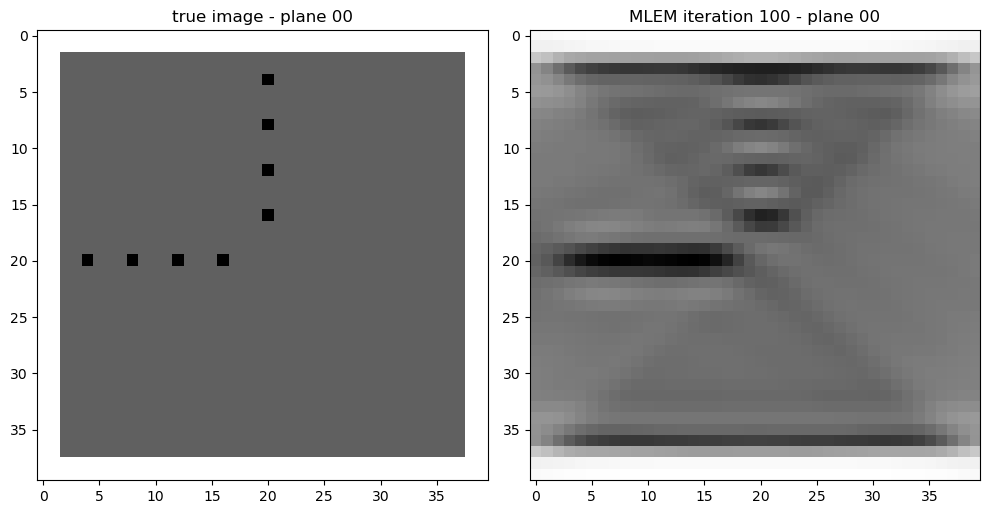

In [22]:
def _update_img(i):
    img0.set_data(x_true_np[:, :, i])
    img1.set_data(x_np[:, :, i])
    ax[0].set_title(f"true image - plane {i:02}")
    ax[1].set_title(f"MLEM iteration {num_iter} - plane {i:02}")
    return (img0, img1)


x_true_np = parallelproj.to_numpy_array(x_true)
x_np = parallelproj.to_numpy_array(x)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vmax = x_np.max()
img0 = ax[0].imshow(x_true_np[:, :, 0], cmap="Greys", vmin=0, vmax=vmax)
img1 = ax[1].imshow(x_np[:, :, 0], cmap="Greys", vmin=0, vmax=vmax)
ax[0].set_title(f"true image - plane {0:02}")
ax[1].set_title(f"MLEM iteration {num_iter} - plane {0:02}")
fig.tight_layout()
ani = animation.FuncAnimation(fig, _update_img, x_np.shape[2], interval=200, blit=False)
fig.show()